Licensed to the Apache Software Foundation (ASF) under one
or more contributor license agreements.  See the NOTICE file
distributed with this work for additional information
regarding copyright ownership.  The ASF licenses this file
to you under the Apache License, Version 2.0 (the
"License"); you may not use this file except in compliance
with the License.  You may obtain a copy of the License at

  http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
KIND, either express or implied.  See the License for the
specific language governing permissions and limitations
under the License.

# Experiments with Sparse Labeling

In [1]:
import os
import math
import json

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import sklearn

import torch

import ucr
import scikit_wrappers

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# GPU number
gpu = 0

In [4]:
np.random.seed(0)
torch.manual_seed(0)

### Dataset

In [5]:
path = 'Data/UCR' # Path to datasets
dataset = 'TwoPatterns'

In [6]:
train, train_labels, test, test_labels = ucr.load_UCR_dataset(path, dataset)

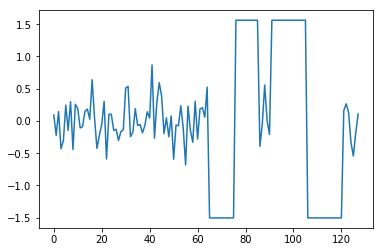

In [7]:
plt.plot(test[0, 0])

## Loading the encoder

In [8]:
model_path = '' # Folder containing the saved model

In [9]:
classifier = scikit_wrappers.CausalCNNEncoderClassifier()
hf = open(
    os.path.join(
        model_path, dataset + '_hyperparameters.json'
    ), 'r'
)
hp_dict = json.load(hf)
hf.close()
hp_dict['cuda'] = True
hp_dict['gpu'] = gpu
classifier.set_params(**hp_dict)
classifier.load(os.path.join(model_path, dataset ))

In [10]:
# Original classifier score
classifier.score(test, test_labels)

0.99975

## Sparse Labeling

In [11]:
# Tested number of labels
nb_labels_list = [int(12 * pow(1.25, i)) for i in range(20)]

In [12]:
# Precompute the frozen representations for efficiency puproses
train_features = classifier.encode(train)
test_features = classifier.encode(test)

In [13]:
# Learns an SVM for each 5 different splits for each tested number of labels
for nb_labels in nb_labels_list:
    results = []
    for i in range(5):
        split = sklearn.model_selection.train_test_split(
            train_features, train_labels, train_size=nb_labels, stratify=train_labels
        )
        classifier.fit_classifier(split[0], split[2])
        results.append(classifier.classifier.score(test_features, test_labels))
    print(nb_labels, np.mean(results), np.std(results))

12 0.7198 0.07630930480616373
15 0.8053500000000001 0.04000018749956055
18 0.7750999999999999 0.03526102664415773
23 0.8804500000000001 0.035383400062741266
29 0.8980499999999999 0.041716123981022035
36 0.9004999999999999 0.037496666518505375
45 0.9417 0.021591317699482814
57 0.9599500000000001 0.020026482466973566
71 0.9794499999999999 0.011272089424769514
89 0.9849500000000001 0.004945705207551294
111 0.99215 0.005582562135793905
139 0.9944000000000001 0.0038065732621348613
174 0.99695 0.0008717797887081673
218 0.99825 0.0009486832980504971
272 0.99885 0.0005385164807134529
341 0.9986499999999999 0.0007176350047203738
426 0.9992500000000002 0.0003162277660168558
532 0.9993500000000001 0.0004636809247747796
666 0.9996 0.00030000000000001873
832 0.9998000000000001 0.00018708286933867647


In [14]:
# Case where no label is missing
results = []
for i in range(5):
    classifier.fit_classifier(train_features, train_labels)
    results.append(classifier.classifier.score(test_features, test_labels))
print(np.shape(train_features)[0], np.mean(results), np.std(results))

1000 0.99975 0.0
